In [1]:
from pymongo import MongoClient
from bson.objectid import ObjectId
import matplotlib, math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
host = 'localhost'
port = 27017
username = ''
password = ''
database = 'tcc-recsys-mongo'

client = MongoClient(host, port)
db = client[database]

In [3]:
filmes = 0
games = 0
livros = 0
musica = 0
for prod in db.produto_novo.find({"categorias":{"$exists":True}}):
    if prod['categorias'][1] == u'Filmes':
        filmes = filmes + 1
    elif prod['categorias'][1] == u'Games':
        games = games + 1
    elif prod['categorias'][1] == u'Livros':
        livros = livros + 1
    else:
        musica = musica + 1
print(filmes)
print(games)
print(livros)
print(musica)

2637
667
9168
298


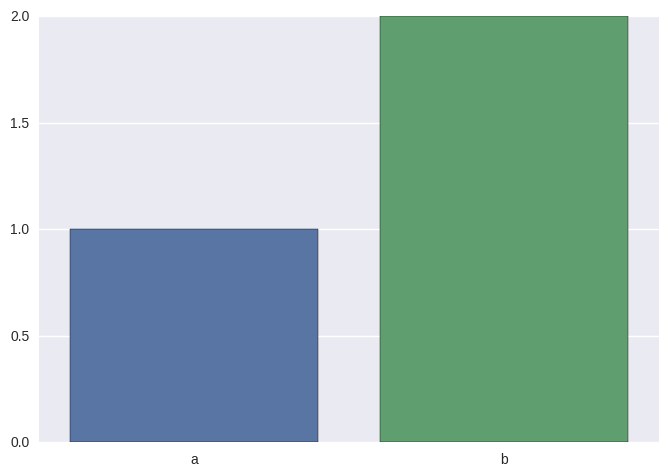

In [4]:
sns.barplot(['a', 'b'], [1,2] )
plt.show()

In [5]:
#pegando maior similaridade de todas as recomendações
maior_similaridade_sistema = 0
for user in db.users.find({"avaliacoes":{"$exists":True}}):
    for avaliacao in user['avaliacoes']:
        if avaliacao['similaridade'] > maior_similaridade_sistema:
            maior_similaridade_sistema = avaliacao['similaridade']
print float(maior_similaridade_sistema)*10

0.706469350748


In [6]:
num_avaliacoes_total = 0
soma_total = 0
recs = []
for user in db.users.find({"avaliacoes":{"$exists":True}}):
    #pegando a maior similaridade do usuario
    maior_similaridade_usuario = 0
    for avaliacao in user['avaliacoes']:
        if avaliacao['similaridade'] > maior_similaridade_usuario:
            maior_similaridade_usuario = avaliacao['similaridade']
            
    soma_usuario = 0
    for avaliacao in user['avaliacoes']:
        prod = db.produto_novo.find_one({'_id': ObjectId(avaliacao['idprod'])})
        nota_sistema = int(float(avaliacao['similaridade'])/float(maior_similaridade_usuario)*4) +1
        
        for recomendacao in user['recomendacoes']:
            for product_rec in recomendacao['products']:
                if product_rec['idprod'] == avaliacao['idprod']:
                    produto_recomendacao = product_rec['nome']
                    post_recomendacao =  recomendacao['post']
                    
        recs.append([float(avaliacao['similaridade'])*10, prod['nome'], avaliacao['nota'], nota_sistema, produto_recomendacao, post_recomendacao])
        #calculo de RMSE
        dif_2 = math.sqrt(pow((int(avaliacao['nota'])-nota_sistema), 2))
        soma_usuario = soma_usuario + dif_2
        
        num_avaliacoes_total = num_avaliacoes_total + 1
        
    soma_total = soma_total + soma_usuario
    
rmse = math.sqrt(float(1)/num_avaliacoes_total*soma_total)
print "O RMSE foi de {}".format(rmse)

O RMSE foi de 1.21948165464


In [7]:
from itertools import groupby
from operator import itemgetter
from tabulate import tabulate

#reduce por similaridade
def reduce_value(obj1, obj2):
    return (obj1[0], obj1[1]+obj2[1])

sim_grouped = [reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (round(x[0],2), 1), recs)), key=itemgetter(0))]

print "Quantidade de recomendações geradas por range de similaridade"
print tabulate(map(lambda x: (x[0], x[1], x[1]/float(len(recs))*100), sim_grouped))

Quantidade de recomendações geradas por range de similaridade
----  ---  ---------
0      44   7.54717
0.01  198  33.9623
0.02   97  16.6381
0.03   93  15.952
0.04   53   9.09091
0.05   17   2.91595
0.06   20   3.43053
0.07   17   2.91595
0.08    7   1.20069
0.09    9   1.54374
0.1    10   1.71527
0.11    4   0.686106
0.12    2   0.343053
0.13    7   1.20069
0.15    1   0.171527
0.16    1   0.171527
0.2     1   0.171527
0.28    1   0.171527
0.71    1   0.171527
----  ---  ---------


In [8]:
def reduce_value(obj1, obj2):
    return (obj1[0], obj1[1]+obj2[1], obj1[2]+obj2[2])

dif_grouped = [reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (abs(int(x[2])-int(x[3])), x[0], 1), recs)), key=itemgetter(0))]
not_usr_grouped = [reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (x[2], x[0], 1), recs)), key=itemgetter(0))]
not_sys_grouped = [reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (x[3], x[0], 1), recs)), key=itemgetter(0))]
print(len(recs))
print "Quantidade de recomendações geradas por diferença entre a nota do sistema e a nota do usuário"
print tabulate(map(lambda x: (x[0], x[2], x[1]/x[2], float(x[2])/float(len(recs))*100), dif_grouped))

print "Quantidade de notas do usuário"
print tabulate(map(lambda x: (x[0], x[2], x[1]/x[2], float(x[2])/float(len(recs))*100), not_usr_grouped))
print "Quantidade de notas do sistema"
print tabulate(map(lambda x: (x[0], x[2], x[1]/x[2], float(x[2])/float(len(recs))*100), not_sys_grouped))


583
Quantidade de recomendações geradas por diferença entre a nota do sistema e a nota do usuário
-  ---  ---------  --------
0  103  0.0312259  17.6672
1  223  0.0237835  38.2504
2  159  0.0280383  27.2727
3   66  0.0335708  11.3208
4   32  0.0781338   5.48885
-  ---  ---------  --------
Quantidade de notas do usuário
-  ---  ---------  --------
1  243  0.0334754  41.681
2   57  0.0240073   9.77702
3  131  0.0255818  22.47
4   63  0.0306005  10.8062
5   89  0.0327194  15.2659
-  ---  ---------  --------
Quantidade de notas do sistema
-  ---  ---------  --------
1   57  0.0375235   9.77702
2  245  0.0215274  42.024
3  169  0.0264955  28.988
4   46  0.0368126   7.89022
5   66  0.0622702  11.3208
-  ---  ---------  --------


In [9]:
for rec in recs:
    if rec[0]>= 0.2:
        print rec    

[0.7064693507478099, u'O que e Vida ? 50 Anos Depois ', u'1', 5, u'O que e Vida ? 50 Anos Depois ', [57, u'Eu na vida  Hahahahhahahaahahahaha haha E tchau  Fui   ', u'Post', u'Facebook']]
[0.20191218713942, u'Historia da Cidade - 4\xaa Ed. ', u'4', 3, u'Historia da Cidade - 4\xaa Ed. ', [56, u'Historia da minha vida       masacabou  historiademuitagente', u'Post', u'Facebook']]
[0.28433448506024, u'O que e Vida ? 50 Anos Depois ', u'3', 5, u'O que e Vida ? 50 Anos Depois ', [78, u'Faco muita escolha errada nessa vida  mas essa com certeza nao foi uma delas   orgulhodeser  gratadeser   Todo ano ela faz tudo sempre igual     melhordobrasil  D', u'Post', u'Facebook']]


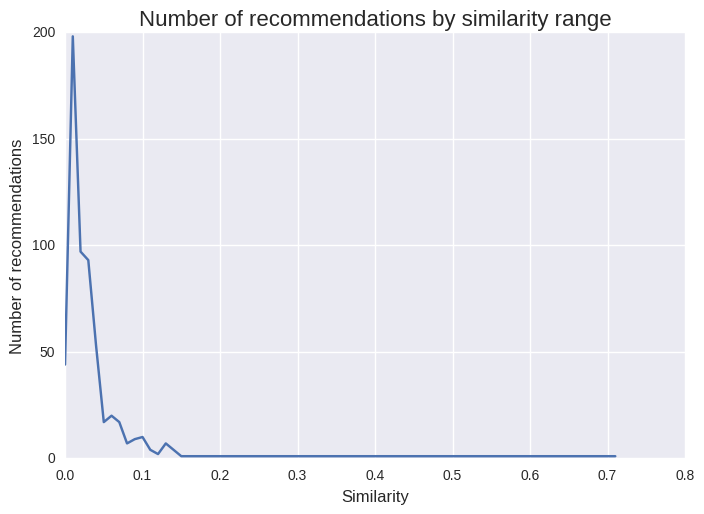

In [10]:
sns.set_style("darkgrid")
plt.plot(map(lambda x: x[0], sim_grouped), map(lambda x: x[1], sim_grouped))
plt.ylabel('Number of recommendations', fontsize=12)
plt.xlabel('Similarity', fontsize=12)
plt.title('Number of recommendations by similarity range'.decode('utf-8'), fontsize=16)
plt.show()

In [11]:
#map(lambda x: x[0], dif_grouped)
map(lambda x: x[2], dif_grouped)
[0, 1]
[103, 223+159+66+32]

[103, 480]

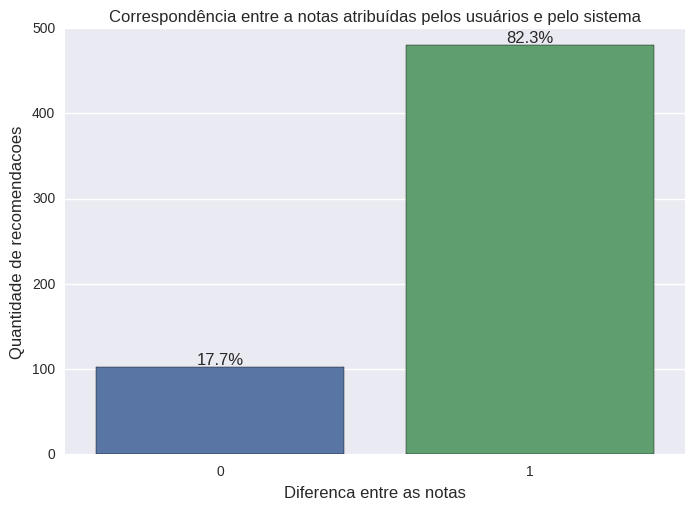

In [12]:
#df = pd.DataFrame()

#df['dif'] = map(lambda x: x[0], dif_grouped)
#df['qtd'] = map(lambda x: x[2], dif_grouped)
#df.head()
total = float(len(recs)) 
ax = sns.barplot([0, 1],  [103, 223+159+66+32])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/total*100),
            ha="center") 

plt.ylabel('Quantidade de recomendacoes', fontsize=12)
plt.xlabel('Diferenca entre as notas', fontsize=12)
plt.title('Correspondência entre a notas atribuídas pelos usuários e pelo sistema'.decode('utf-8'), fontsize=12)
plt.show()

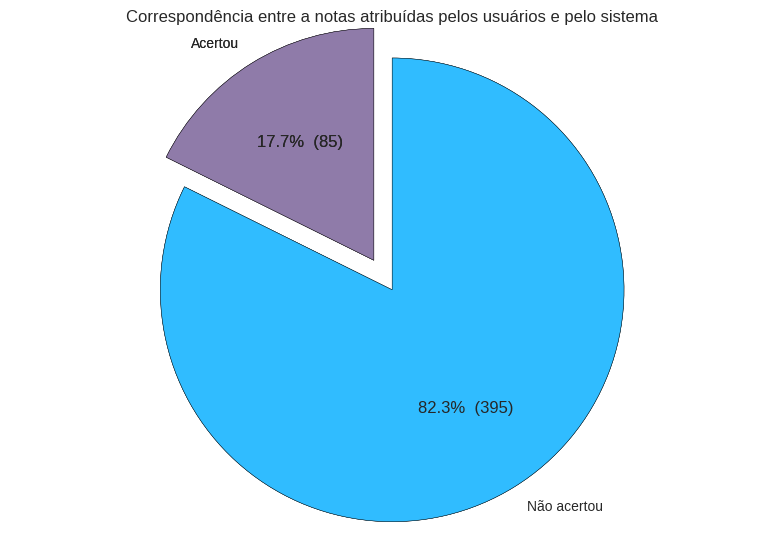

In [31]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
colors = ["#8f7ba9", "#30bcff"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    [103, 223+159+66+32],
    # with the labels being, officer names
    labels=["Acertou", "Não acertou".decode('utf-8')],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct=make_autopct([223+159+66+32]),
    )

# View the plot drop above
plt.axis('equal')
plt.title('Correspondência entre a notas atribuídas pelos usuários e pelo sistema'.decode('utf-8'), fontsize=12)
# View the plot
plt.tight_layout()
plt.show()